In [82]:
import argparse
import openml
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision
from torchvision.transforms import Compose, ToTensor, Resize
from torch import optim
import numpy as np
import pandas as pd
from torch.hub import tqdm

In [83]:
# Import dependencies
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_moons
from sklearn.model_selection import train_test_split

In [84]:
# Set the hyperparameters for data creation
NUM_CLASSES = 2
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_data, y_data = make_moons(n_samples=1000,random_state=RANDOM_SEED)

X_data = torch.from_numpy(X_data).type(torch.float)
y_data = torch.from_numpy(y_data).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(X_data,y_data,random_state=RANDOM_SEED,test_size=0.2)


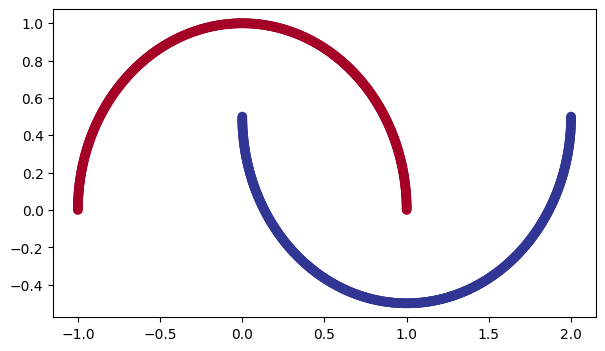

In [85]:
plt.figure(figsize=(7, 4))
plt.scatter(X_data[:, 0], X_data[:, 1], c=y_data, cmap=plt.cm.RdYlBu)

In [86]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [87]:
class patrickNeuralNetwork(nn.Module):
    def __init__(self,n_features,output_features,hidden_units=8) :
        super().__init__()
        self.linearStack = nn.Sequential(
            nn.Linear(in_features=n_features,out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=output_features)
        )
    
    def forward(self,x):
        return self.linearStack(x)

In [88]:
model = patrickNeuralNetwork(NUM_FEATURES,output_features=1).to(device)
model

patrickNeuralNetwork(
  (linearStack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=8, bias=True)
    (5): ReLU()
    (6): Linear(in_features=8, out_features=1, bias=True)
  )
)

In [89]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)

In [90]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

In [ ]:
print(y_data)

In [92]:
from torchmetrics import Accuracy

torch.manual_seed(RANDOM_SEED)
#torch.seed(RANDOM_SEED)

epochs = 100

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)
Acc = Accuracy(task="binary")
for epoch in range(epochs):

    model.train()

    y_logits = model(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    
    #quand on utilise une loss fonction BCEwithLogitsLoss, on passe les logits en comparaison
    loss = loss_fn(y_logits,y_train)

    acc = Acc(y_train,y_pred)
    
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.eval()

    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits))

      # 2. Calculate test loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = Acc(y_test,test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.70254, Acc: 0.50% | Test Loss: 0.69781, Test Acc: 0.50%
Epoch: 10 | Loss: 0.66220, Acc: 0.72% | Test Loss: 0.66050, Test Acc: 0.69%
Epoch: 20 | Loss: 0.56928, Acc: 0.79% | Test Loss: 0.57184, Test Acc: 0.76%
Epoch: 30 | Loss: 0.43366, Acc: 0.81% | Test Loss: 0.44159, Test Acc: 0.80%
Epoch: 40 | Loss: 0.30774, Acc: 0.86% | Test Loss: 0.30700, Test Acc: 0.85%
Epoch: 50 | Loss: 0.23427, Acc: 0.89% | Test Loss: 0.23368, Test Acc: 0.90%
Epoch: 60 | Loss: 0.20902, Acc: 0.90% | Test Loss: 0.19990, Test Acc: 0.92%
Epoch: 70 | Loss: 0.18585, Acc: 0.91% | Test Loss: 0.18057, Test Acc: 0.93%
Epoch: 80 | Loss: 0.15221, Acc: 0.93% | Test Loss: 0.14190, Test Acc: 0.94%
Epoch: 90 | Loss: 0.09879, Acc: 0.97% | Test Loss: 0.08309, Test Acc: 0.98%


In [96]:
data = {361066: {8: ('classification', 0.7617396785376616), 20: ('classification', 0.7670973841790104), 50: ('classification', 0.7658367475575165), 100: ('classification', 0.7630003151591553), 180: ('classification', 0.7642609517806492), 200: ('classification', 0.7295934446895682)}, 361076: {8: ('regression', 0.7306415), 20: ('regression', 0.7323228), 50: ('regression', 0.7366748), 100: ('regression', 0.7393718), 180: ('regression', 0.74325174), 200: ('regression', 0.75782114)}, 361085: {8: ('regression', 0.04658459111295309), 20: ('regression', 0.04509640814057335), 50: ('regression', 0.04940557568445352), 100: ('regression', 0.047847488398478216), 180: ('regression', 0.04854184062137413), 200: ('regression', 0.05001452633494936)}, 361088: {8: ('regression', 13.6638459103719), 20: ('regression', 14.196785975932952), 50: ('regression', 14.778095502340939), 100: ('regression', 15.144033906155393), 180: ('regression', 15.445019918673523), 200: ('regression', 16.01074518854403)}, 361089: {8: ('regression', 0.2509209022474643), 20: ('regression', 0.24841141236436243), 50: ('regression', 0.25085037782143976), 100: ('regression', 0.24395926041547616), 180: ('regression', 0.24342003006942206), 200: ('regression', 0.24434967451282638)}, 361110: {8: ('classification', 0.7688442211055276), 20: ('classification', 0.7685843008144169), 50: ('classification', 0.7634725350892393), 100: ('classification', 0.7492635591751863), 180: ('classification', 0.7575810084907295), 200: ('classification', 0.7425922717033443)}, 361111: {8: ('classification', 0.551270815074496), 20: ('classification', 0.535056967572305), 50: ('classification', 0.5560911481156879), 100: ('classification', 0.5683610867659947), 180: ('classification', 0.537248028045574), 200: ('classification', 0.5416301489921121)}, 361112: {8: ('classification', 0.7456953642384105), 20: ('classification', 0.7245033112582782), 50: ('classification', 0.7278145695364239), 100: ('classification', 0.7311258278145696), 180: ('classification', 0.7178807947019867), 200: ('classification', 0.7092715231788079)}, 361114: {8: ('classification', 0.6391683433936955), 20: ('classification', 0.6096579476861167), 50: ('classification', 0.6398390342052314), 100: ('classification', 0.613682092555332), 180: ('classification', 0.6042924211938296), 200: ('classification', 0.6049631120053656)}, 361116: {8: ('classification', 0.6843581013418786), 20: ('classification', 0.6639295013018226), 50: ('classification', 0.6701381934708592), 100: ('classification', 0.6431003404766673), 180: ('classification', 0.6368916483076307), 200: ('classification', 0.607450430602844)}, 361099: {8: ('regression', 115.25619442923029), 20: ('regression', 115.29041452104958), 50: ('regression', 115.66978709909198), 100: ('regression', 117.07590066432115), 180: ('regression', 117.0340408440459), 200: ('regression', 118.95057888927539)}, 361102: {8: ('regression', 0.2719617793725434), 20: ('regression', 0.2670074179422034), 50: ('regression', 0.27807784048015866), 100: ('regression', 0.27455031718864176), 180: ('regression', 0.28152496852442505), 200: ('regression', 0.3145449846655261)}}
data[361099]

{8: ('regression', 115.25619442923029),
 20: ('regression', 115.29041452104958),
 50: ('regression', 115.66978709909198),
 100: ('regression', 117.07590066432115),
 180: ('regression', 117.0340408440459),
 200: ('regression', 118.95057888927539)}

In [ ]:
import matplotlib.pyplot as plt

results_emb = {361066: {8: ('classification', 0.7617396785376616), 20: ('classification', 0.7670973841790104), 50: ('classification', 0.7658367475575165), 100: ('classification', 0.7630003151591553), 180: ('classification', 0.7642609517806492), 200: ('classification', 0.7295934446895682)}, 361076: {8: ('regression', 0.7306415), 20: ('regression', 0.7323228), 50: ('regression', 0.7366748), 100: ('regression', 0.7393718), 180: ('regression', 0.74325174), 200: ('regression', 0.75782114)}, 361085: {8: ('regression', 0.04658459111295309), 20: ('regression', 0.04509640814057335), 50: ('regression', 0.04940557568445352), 100: ('regression', 0.047847488398478216), 180: ('regression', 0.04854184062137413), 200: ('regression', 0.05001452633494936)}, 361088: {8: ('regression', 13.6638459103719), 20: ('regression', 14.196785975932952), 50: ('regression', 14.778095502340939), 100: ('regression', 15.144033906155393), 180: ('regression', 15.445019918673523), 200: ('regression', 16.01074518854403)}, 361089: {8: ('regression', 0.2509209022474643), 20: ('regression', 0.24841141236436243), 50: ('regression', 0.25085037782143976), 100: ('regression', 0.24395926041547616), 180: ('regression', 0.24342003006942206), 200: ('regression', 0.24434967451282638)}, 361110: {8: ('classification', 0.7688442211055276), 20: ('classification', 0.7685843008144169), 50: ('classification', 0.7634725350892393), 100: ('classification', 0.7492635591751863), 180: ('classification', 0.7575810084907295), 200: ('classification', 0.7425922717033443)}, 361111: {8: ('classification', 0.551270815074496), 20: ('classification', 0.535056967572305), 50: ('classification', 0.5560911481156879), 100: ('classification', 0.5683610867659947), 180: ('classification', 0.537248028045574), 200: ('classification', 0.5416301489921121)}, 361112: {8: ('classification', 0.7456953642384105), 20: ('classification', 0.7245033112582782), 50: ('classification', 0.7278145695364239), 100: ('classification', 0.7311258278145696), 180: ('classification', 0.7178807947019867), 200: ('classification', 0.7092715231788079)}, 361114: {8: ('classification', 0.6391683433936955), 20: ('classification', 0.6096579476861167), 50: ('classification', 0.6398390342052314), 100: ('classification', 0.613682092555332), 180: ('classification', 0.6042924211938296), 200: ('classification', 0.6049631120053656)}, 361116: {8: ('classification', 0.6843581013418786), 20: ('classification', 0.6639295013018226), 50: ('classification', 0.6701381934708592), 100: ('classification', 0.6431003404766673), 180: ('classification', 0.6368916483076307), 200: ('classification', 0.607450430602844)}, 361099: {8: ('regression', 115.25619442923029), 20: ('regression', 115.29041452104958), 50: ('regression', 115.66978709909198), 100: ('regression', 117.07590066432115), 180: ('regression', 117.0340408440459), 200: ('regression', 118.95057888927539)}, 361102: {8: ('regression', 0.2719617793725434), 20: ('regression', 0.2670074179422034), 50: ('regression', 0.27807784048015866), 100: ('regression', 0.27455031718864176), 180: ('regression', 0.28152496852442505), 200: ('regression', 0.3145449846655261)}}

# Separate data for regression and classification tasks
regression_data = {k: v for k, v in results_emb.items() if v[list(v.keys())[0]][0] == 'regression'}
classification_data = {k: v for k, v in results_emb.items() if v[list(v.keys())[0]][0] == 'classification'}

# Plot for regression task
plt.figure(figsize=(10, 6))
for key, values in regression_data.items():
    embedding_sizes = list(values.keys())
    scores = [value[1] for value in values.values()]
    plt.plot(embedding_sizes, scores, label=f"Dataset {key}")
plt.title("Regression Task Performance with Different Embedding Sizes")
plt.xlabel("Embedding Size")
plt.ylabel("RMSE")
plt.legend()
plt.show()

# Plot for classification task
plt.figure(figsize=(10, 6))
for key, values in classification_data.items():
    embedding_sizes = list(values.keys())
    scores = [value[1] for value in values.values()]
    plt.plot(embedding_sizes, scores, label=f"Dataset {key}")
plt.title("Classification Task Performance with Different Embedding Sizes")
plt.xlabel("Embedding Size")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [2]:
results_method_features = {361066: {'baseline': 78.178, 'numEncoder_Encoding': 74.775, 'numEncoder_Embeddings': 77.327, 'feature2vec': 76.149}, 361076: {'baseline': 0.688, 'numEncoder_Encoding': 0.687, 'numEncoder_Embeddings': 0.694, 'feature2vec': 0.744}, 361085: {'baseline': 0.025, 'numEncoder_Encoding': 0.021, 'numEncoder_Embeddings': 0.023, 'feature2vec': 0.045}, 361088: {'baseline': 11.006, 'numEncoder_Encoding': 11.138, 'numEncoder_Embeddings': 11.461, 'feature2vec': 13.774}, 361089: {'baseline': 0.165, 'numEncoder_Encoding': 0.162, 'numEncoder_Embeddings': 0.167, 'feature2vec': 0.249}, 361110: {'baseline': 84.001, 'numEncoder_Encoding': 85.25, 'numEncoder_Embeddings': 84.488, 'feature2vec': 77.098}, 361111: {'baseline': 57.8, 'numEncoder_Encoding': 59.755, 'numEncoder_Embeddings': 58.782, 'feature2vec': 55.285}, 361112: {'baseline': 74.795, 'numEncoder_Encoding': 75.258, 'numEncoder_Embeddings': 74.742, 'feature2vec': 74.702}, 361114: {'baseline': 66.586, 'numEncoder_Encoding': 68.786, 'numEncoder_Embeddings': 68.706, 'feature2vec': 62.83}, 361116: {'baseline': 73.178, 'numEncoder_Encoding': 72.802, 'numEncoder_Embeddings': 72.778, 'feature2vec': 69.189}, 361099: {'baseline': 63.886, 'numEncoder_Encoding': 47.215, 'numEncoder_Embeddings': 57.575, 'feature2vec': 115.786}, 361102: {'baseline': 0.226, 'numEncoder_Encoding': 0.195, 'numEncoder_Embeddings': 0.208, 'feature2vec': 0.28}}
results_method_features

{361066: {'baseline': 78.178,
  'numEncoder_Encoding': 74.775,
  'numEncoder_Embeddings': 77.327,
  'feature2vec': 76.149},
 361076: {'baseline': 0.688,
  'numEncoder_Encoding': 0.687,
  'numEncoder_Embeddings': 0.694,
  'feature2vec': 0.744},
 361085: {'baseline': 0.025,
  'numEncoder_Encoding': 0.021,
  'numEncoder_Embeddings': 0.023,
  'feature2vec': 0.045},
 361088: {'baseline': 11.006,
  'numEncoder_Encoding': 11.138,
  'numEncoder_Embeddings': 11.461,
  'feature2vec': 13.774},
 361089: {'baseline': 0.165,
  'numEncoder_Encoding': 0.162,
  'numEncoder_Embeddings': 0.167,
  'feature2vec': 0.249},
 361110: {'baseline': 84.001,
  'numEncoder_Encoding': 85.25,
  'numEncoder_Embeddings': 84.488,
  'feature2vec': 77.098},
 361111: {'baseline': 57.8,
  'numEncoder_Encoding': 59.755,
  'numEncoder_Embeddings': 58.782,
  'feature2vec': 55.285},
 361112: {'baseline': 74.795,
  'numEncoder_Encoding': 75.258,
  'numEncoder_Embeddings': 74.742,
  'feature2vec': 74.702},
 361114: {'baseline': 6

In [8]:
results_method_sample = {361066: {'baseline': 78.664, 'numEncoder_Encoding': 76.785, 'numEncoder_Embeddings': 77.636, 'feature2vec': 76.117}, 361076: {'baseline': 0.697, 'numEncoder_Encoding': 0.689, 'numEncoder_Embeddings': 0.7, 'feature2vec': 0.746}, 361085: {'baseline': 0.024, 'numEncoder_Encoding': 0.021, 'numEncoder_Embeddings': 0.022, 'feature2vec': 0.043}, 361088: {'baseline': 12.164, 'numEncoder_Encoding': 11.926, 'numEncoder_Embeddings': 12.06, 'feature2vec': 13.668}, 361089: {'baseline': 0.168, 'numEncoder_Encoding': 0.163, 'numEncoder_Embeddings': 0.167, 'feature2vec': 0.249}, 361110: {'baseline': 83.531, 'numEncoder_Encoding': 84.786, 'numEncoder_Embeddings': 83.776, 'feature2vec': 77.285}, 361111: {'baseline': 58.23, 'numEncoder_Encoding': 59.115, 'numEncoder_Embeddings': 58.221, 'feature2vec': 56.109}, 361112: {'baseline': 74.106, 'numEncoder_Encoding': 75.536, 'numEncoder_Embeddings': 75.523, 'feature2vec': 73.43}, 361114: {'baseline': 65.822, 'numEncoder_Encoding': 69.39, 'numEncoder_Embeddings': 67.753, 'feature2vec': 62.643}, 361116: {'baseline': 72.602, 'numEncoder_Encoding': 71.809, 'numEncoder_Embeddings': 71.809, 'feature2vec': 69.381}, 361099: {'baseline': 96.925, 'numEncoder_Encoding': 65.05, 'numEncoder_Embeddings': 87.007, 'feature2vec': 113.567}, 361102: {'baseline': 0.218, 'numEncoder_Encoding': 0.203, 'numEncoder_Embeddings': 0.215, 'feature2vec': 0.278}}

results_method_sample

{361066: {'baseline': 78.664,
  'numEncoder_Encoding': 76.785,
  'numEncoder_Embeddings': 77.636,
  'feature2vec': 76.117},
 361076: {'baseline': 0.697,
  'numEncoder_Encoding': 0.689,
  'numEncoder_Embeddings': 0.7,
  'feature2vec': 0.746},
 361085: {'baseline': 0.024,
  'numEncoder_Encoding': 0.021,
  'numEncoder_Embeddings': 0.022,
  'feature2vec': 0.043},
 361088: {'baseline': 12.164,
  'numEncoder_Encoding': 11.926,
  'numEncoder_Embeddings': 12.06,
  'feature2vec': 13.668},
 361089: {'baseline': 0.168,
  'numEncoder_Encoding': 0.163,
  'numEncoder_Embeddings': 0.167,
  'feature2vec': 0.249},
 361110: {'baseline': 83.531,
  'numEncoder_Encoding': 84.786,
  'numEncoder_Embeddings': 83.776,
  'feature2vec': 77.285},
 361111: {'baseline': 58.23,
  'numEncoder_Encoding': 59.115,
  'numEncoder_Embeddings': 58.221,
  'feature2vec': 56.109},
 361112: {'baseline': 74.106,
  'numEncoder_Encoding': 75.536,
  'numEncoder_Embeddings': 75.523,
  'feature2vec': 73.43},
 361114: {'baseline': 65.

In [2]:
regression_sample 

{361076: {'baseline': ('regression', 0.6947048),
  'numEncoder_Encoding': ('regression', 0.70837706),
  'numEncoder_Embeddings': ('regression', 0.72519064),
  'feature2vec': ('regression', 0.762406)},
 361085: {'baseline': ('regression', 0.02157667593129203),
  'numEncoder_Encoding': ('regression', 0.020731494758317863),
  'numEncoder_Embeddings': ('regression', 0.023213502595600923),
  'feature2vec': ('regression', 0.04606333004329112)},
 361088: {'baseline': ('regression', 12.275849519158864),
  'numEncoder_Encoding': ('regression', 12.387720810563492),
  'numEncoder_Embeddings': ('regression', 13.250100068284011),
  'feature2vec': ('regression', 15.043820201191872)},
 361089: {'baseline': ('regression', 0.16950578699238583),
  'numEncoder_Encoding': ('regression', 0.16298572856313967),
  'numEncoder_Embeddings': ('regression', 0.17879031260333378),
  'feature2vec': ('regression', 0.2365624359618306)},
 361099: {'baseline': ('regression', 97.89084318885389),
  'numEncoder_Encoding': 

In [6]:
rounded_results = {}

for dataset_id, results in regression_sample.items():
    rounded_results[dataset_id] = {}
    for method, (task, metric) in results.items():
        rounded_metric = round(metric, 3)
        rounded_results[dataset_id][method] = rounded_metric

rounded_results

{361076: {'baseline': 0.695,
  'numEncoder_Encoding': 0.708,
  'numEncoder_Embeddings': 0.725,
  'feature2vec': 0.762},
 361085: {'baseline': 0.022,
  'numEncoder_Encoding': 0.021,
  'numEncoder_Embeddings': 0.023,
  'feature2vec': 0.046},
 361088: {'baseline': 12.276,
  'numEncoder_Encoding': 12.388,
  'numEncoder_Embeddings': 13.25,
  'feature2vec': 15.044},
 361089: {'baseline': 0.17,
  'numEncoder_Encoding': 0.163,
  'numEncoder_Embeddings': 0.179,
  'feature2vec': 0.237},
 361099: {'baseline': 97.891,
  'numEncoder_Encoding': 75.174,
  'numEncoder_Embeddings': 106.301,
  'feature2vec': 118.722},
 361102: {'baseline': 0.217,
  'numEncoder_Encoding': 0.217,
  'numEncoder_Embeddings': 0.229,
  'feature2vec': 0.289}}

In [8]:
rounded_results1 = {}

for dataset_id, results in classification_sample.items():
    rounded_results1[dataset_id] = {}
    for method, (task, metric) in results.items():
        rounded_metric = round(metric, 3)
        rounded_results1[dataset_id][method] = rounded_metric

rounded_results1

{361066: {'baseline': 77.687,
  'numEncoder_Encoding': 75.701,
  'numEncoder_Embeddings': 77.498,
  'feature2vec': 76.174},
 361110: {'baseline': 83.824,
  'numEncoder_Encoding': 84.006,
  'numEncoder_Embeddings': 81.268,
  'feature2vec': 76.382},
 361111: {'baseline': 59.465,
  'numEncoder_Encoding': 59.246,
  'numEncoder_Embeddings': 57.581,
  'feature2vec': 53.856},
 361112: {'baseline': 73.974,
  'numEncoder_Encoding': 77.285,
  'numEncoder_Embeddings': 75.43,
  'feature2vec': 71.788},
 361114: {'baseline': 66.868,
  'numEncoder_Encoding': 67.941,
  'numEncoder_Embeddings': 68.41,
  'feature2vec': 61.033},
 361116: {'baseline': 71.941,
  'numEncoder_Encoding': 69.938,
  'numEncoder_Embeddings': 71.16,
  'feature2vec': 65.492}}

In [ ]:


# 361066 bank-marketing classification
# 361110 electricity classification
# 361111 eye_movements classification
# 361112 KDDCup09_upselling classification
# 361114 rl classification
# 361116 compass classification

: Results for MLP equipped with simple embedding modules (see subsection 4.3). The
metric values averaged over 15 random seeds are reported. The standard deviations are provided
in Appendix F. We consider one result to be better than another if its mean score is better and its
standard deviation is less than the difference. For each dataset, top results are in bold. Notation: ↓
corresponds to RMSE, ↑ corresponds to accuracy

Page 14 Embedding for graph

### Data for the experiment of others techniques

In [1]:
import statsmodels.api as sm
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import category_encoders as ce

RANDOM_SEED = 42


df = pd.read_csv("data/adult.csv")

# Transform the target variable to 0,1

mapping = {"<=50K": 0, ">50K": 1}
df["income"]  = df["income"].map(mapping)

X = df.drop("income",axis=1)
y = df["income"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
X_train


,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country
37193,42,Private,145175,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States
31093,52,Self-emp-not-inc,175029,10th,6,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,35,United-States
33814,34,Local-gov,172664,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States
14500,28,Private,125791,HS-grad,9,Never-married,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States
23399,46,Private,28419,Assoc-voc,11,Never-married,Transport-moving,Not-in-family,White,Male,0,0,50,United-States
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,36,Private,635913,HS-grad,9,Married-spouse-absent,Other-service,Not-in-family,Black,Male,0,0,40,United-States
44732,34,Private,107624,Some-college,10,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,50,United-States
38158,28,Private,250135,Some-college,10,Divorced,Exec-managerial,Not-in-family,White,Female,0,0,40,United-States
860,46,State-gov,96652,Assoc-voc,11,Separated,Adm-clerical,Unmarried,Black,Female,0,0,40,United-States


In [ ]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.manifold import TSNE

tsne = TSNE(n_components=3, random_state=42, init='pca', perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X)

# Plot t-SNE
plt.figure(figsize=(10, 8))
colors = ['r', 'g', 'b']
for i, c, label in zip(range(len(target_names)), colors, target_names):
    plt.scatter(X_tsne[y == i, 0], X_tsne[y == i, 1], c=c, label=label)
plt.title('t-SNE Visualization of Iris Dataset')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.grid(True)
plt.show()


### Hash encoding for categroical features

In [ ]:
from sklearn.utils import murmurhash3_32

def hash_encoding(category):
    return murmurhash3_32(category) & 0xffffffff

X_train_hashed = np.array([hash_encoding(label) for label in X_train])
X_test_hashed = np.array([hash_encoding(label) for label in X_test])

X_train_hashed


### Multi dimensional encoding

In [ ]:
import torch
import torch.nn as nn
from rtdl_num_embeddings import (
    LinearReLUEmbeddings,
    PeriodicEmbeddings,
    PiecewiseLinearEncoding,
    PiecewiseLinearEmbeddings,
    compute_bins,
)
# NOTE: pip install rtdl_revisiting_models
from rtdl_revisiting_models import MLP

batch_size = 256
n_cont_features = 3
x = torch.randn(batch_size, n_cont_features)


In [13]:
numeric_features = X_train.select_dtypes(include=['float64', 'float32', 'float16', 'int64', 'int32', 'int16', 'int8', 'uint8'])
numeric_features

,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week
37193,42,145175,10,0,0,40
31093,52,175029,6,0,0,35
33814,34,172664,9,0,0,40
14500,28,125791,9,0,0,40
23399,46,28419,11,0,0,50
...,...,...,...,...,...,...
11284,36,635913,9,0,0,40
44732,34,107624,10,0,0,50
38158,28,250135,10,0,0,40
860,46,96652,11,0,0,40


In [16]:
num_tensor = torch.tensor(numeric_features.to_numpy(), dtype=torch.float32)
bins = compute_bins(num_tensor)
bins

[tensor([17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27., 28., 29., 30.,
         31., 32., 33., 34., 35., 36., 37., 38., 39., 40., 41., 42., 43., 44.,
         45., 46., 47., 48., 49., 50., 51., 53., 54., 56., 58., 59., 62., 65.,
         69., 90.]),
 tensor([  12285.0000,   31053.0000,   36956.0000,   46699.0000,   55465.0000,
           67929.0078,   79627.0000,   89598.0000,   97939.0000,  103277.0000,
          108233.0000,  113151.0000,  117634.0000,  122353.0000,  127961.0547,
          134331.0000,  140581.0000,  145886.0312,  151580.0000,  156848.0000,
          161944.0000,  166416.0000,  170583.0000,  174685.0000,  177974.0000,
          182227.0000,  186035.0000,  189511.0000,  192932.0000,  196993.9688,
          200679.0000,  205175.0000,  210508.9844,  216208.0000,  222899.0000,
          229826.0000,  237735.0000,  246652.0000,  256416.9062,  267431.0000,
          279452.0000,  292472.0000,  308118.0000,  324791.0000,  342709.0000,
          362835.0000,  393829.

In [22]:
emb = PiecewiseLinearEmbeddings(bins,8,activation=False)
new_rep = emb(num_tensor)

In [29]:
new_rep

tensor([[[ 0.2348,  0.2704,  1.0718,  ..., -0.5643, -0.5655, -0.4959],
         [-0.0683,  0.0071,  0.0322,  ..., -0.0912, -0.2654, -0.5293],
         [ 0.0743, -0.1714, -0.1456,  ..., -0.3974,  0.1932, -0.1480],
         [ 0.0857,  0.0083,  0.0875,  ...,  0.1417,  0.0417, -0.1220],
         [ 0.1024,  0.0078, -0.0914,  ..., -0.0799,  0.0574, -0.0514],
         [-0.3467,  0.2443, -0.2380,  ..., -0.3350, -0.0616, -0.1471]],

        [[-0.0235,  0.0132,  1.3975,  ..., -0.2628, -0.7080, -0.8599],
         [-0.0458, -0.5130,  0.2609,  ..., -0.1456,  0.0533, -0.1228],
         [ 0.3003, -0.0757, -0.2259,  ..., -0.3512,  0.3278, -0.0954],
         [ 0.0857,  0.0083,  0.0875,  ...,  0.1417,  0.0417, -0.1220],
         [ 0.1024,  0.0078, -0.0914,  ..., -0.0799,  0.0574, -0.0514],
         [-0.2743,  0.2514, -0.0197,  ..., -0.3059,  0.0155, -0.3582]],

        [[ 0.0818,  0.3669,  0.7071,  ..., -0.3956, -0.4454, -0.4212],
         [ 0.0290, -0.5039,  0.1887,  ..., -0.1533,  0.0090, -0.1825],
  

### SuperTML encoding